In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split




### Set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [3]:
dataset = datasets.CIFAR10(root='./data', transform=manual_transforms, download=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 43616971.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
train = int(0.8 * len(dataset))
validation = int(0.1 * len(dataset))
test = int(0.1 * len(dataset))

train_data, validation_data, test_data = random_split(dataset, [train, validation, test])
train_dataloader = DataLoader(train_data, batch_size = 16, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)


In [47]:
model = models.efficientnet_b0()
model = model.to(device)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=10)
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))


def validate_function(model, device, validation_dataloader, loss_function, accuracy_function):
  model.eval()
  model = model.to(device)
  validation_loss = 0
  validation_acc = 0

  with torch.inference_mode():
    for X_val, y_val in tqdm(validation_dataloader):
      X_val , y_val = X_val.to(device), y_val.to(device)
      val_logits = model(X_val)
      val_pred = torch.argmax(val_logits, dim=1)
      validation_acc += accuracy_function(y_val, val_pred)
      validation_loss += loss_function(val_logits, y_val)
  return validation_loss/len(validation_dataloader), validation_acc/len(validation_dataloader)


In [65]:
epochs = 5
for epoch in range(epochs):
  train_loss, trng_acc = train_function(model, device, train_dataloader, loss_function, optimizer)
  print(f'Epoch {epoch}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f}')

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 0: Training Loss: 1.1512, Training Accuracy: 59.2300


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1: Training Loss: 1.0584, Training Accuracy: 62.7575


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.9886, Training Accuracy: 65.3925


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.9269, Training Accuracy: 67.4025


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.8714, Training Accuracy: 69.5725


In [66]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for data, target in validation_dataloader:
    data, target = data.to(device), target.to(device)
    outputs = model(data)
    softmax_scores = torch.softmax(outputs, dim=1) # shape should be 16, 10
    true_softmax = softmax_scores.gather(1, target.unsqueeze(1))
    conformal_scores.append(1-true_softmax)



In [67]:

# turn the list of tensors into one tensor
conformal_scores = torch.cat(conformal_scores)


In [68]:
#setting alpha n other hyperparameters
import numpy as np


conformal_scores_numpy = conformal_scores.squeeze().cpu().numpy()


alpha = 0.05
q_level = np.ceil((5000+1)*(1-alpha)) / 5000
qhat = np.quantile(conformal_scores_numpy, q_level, method='higher')


In [69]:
qhat

0.9517847

In [70]:
import random
random.seed(42)
#select 10 indices from the test_data
test_indices = list(range(len(test_data)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_data, selected_indices)


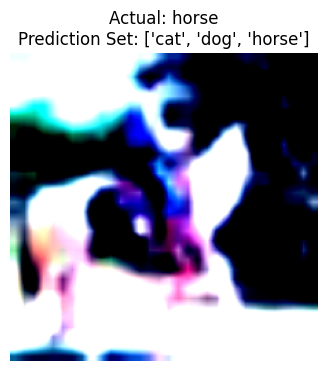

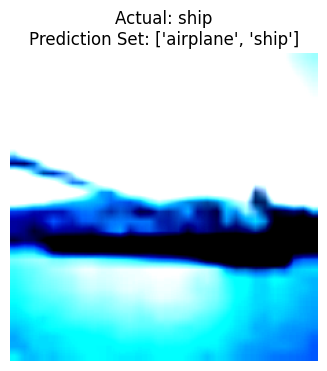

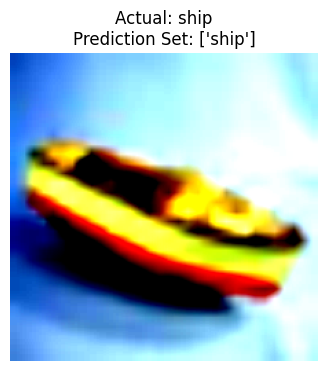

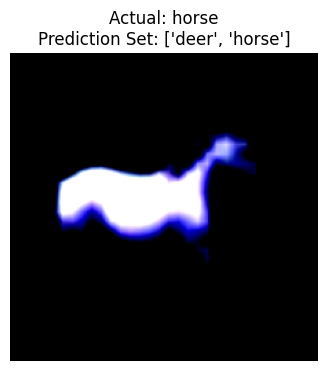

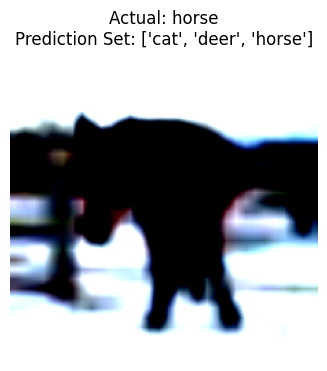

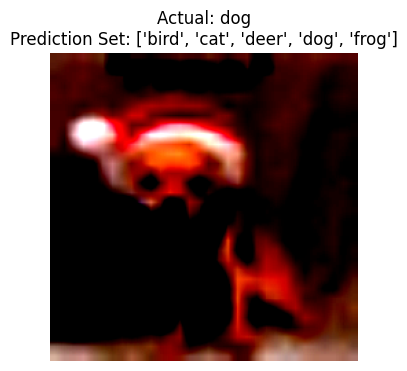

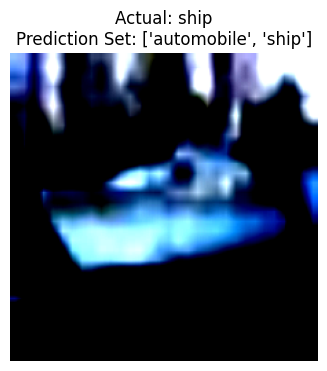

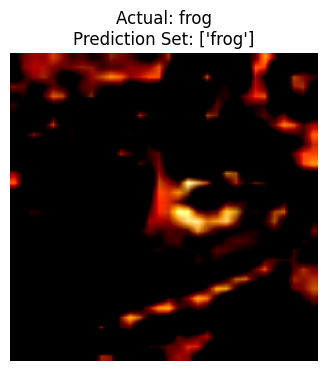

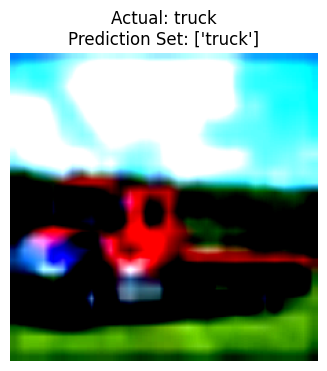

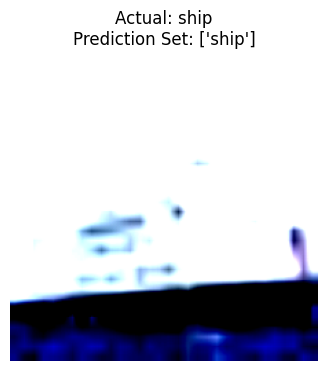

In [77]:
import matplotlib.pyplot as plt

prediction_sets = []
class_names = dataset.classes
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().squeeze().permute(1, 2, 0))
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

